Analisis Eda del proyecto

´´Recordamos las preguntas de investigacion´´

¿Existe relación entre el nivel de urbanización y las tasas de natalidad?  
  
¿Existen patrones regionales o económicos que expliquen diferencias en natalidad? 
  
¿Puede predecirse la tasa de natalidad de un país en base a sus condiciones socioeconómicas? 
  
¿Qué  países  se  comportan  como  outliers  (tienen  tasas  de  natalidad  inusuales  dadas  sus 
características)? 
  
¿Cómo  han  cambiado  las  tasas  de  natalidad  en  las  últimas  dos  décadas,  y  qué  variables  se 
relacionan con esos cambios? 

In [2]:
#utilidades
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sns
import json


 Banco Mundial (https://data.worldbank.org) ​
 Our World in Data (https://ourworldindata.org) ​
 World Meter (https://worldometer.readthedocs.io/en/latest) ​
 Datos Macro (https://datosmacro.expansion.com/demografia/natalidad) ​
 API (https://opengateway.telefonica.com/apis/population-density-data) ​
 https://www.ine.gob.cl/estadisticas/sociales/censos-de-poblacion-y-vivienda/censo-de-poblacion-y-vivienda ​

In [3]:
"""
link_banco_mundial_total = "https://data.worldbank.org/indicator/SP.POP.TOTL"
link_banco_mundial_urbana = "https://data.worldbank.org/indicator/SP.URB.TOTL"
link_banco_mundial_fertilidad = "  https://api.worldbank.org/v2/country/all/indicator/SP.POP.TOTL?format=json"
datos_macro_natalidad_html = "https://datosmacro.expansion.com/demografia/natalidad"

indicadores = ["SP.POP.TOTL","SP.URB.TOTL","SP.POP.TOTL"]
dataframes = []
# Hacemos la primera solicitud para saber cuántas páginas hay
for i in indicadores:
    url_base = f"http://api.worldbank.org/v2/country/all/indicator/{i}?format=json&per_page=100"
    response = requests.get(url_base)
    data = response.json()
    total_pages = data[0]['pages']
    print(f"Total de páginas: {total_pages}")

    # Lista para guardar todos los datos
    all_data = []

    # Iterar por todas las páginas
    for page in range(1, total_pages + 1):
        response = requests.get(f"{url_base}&page={page}")
        page_data = response.json()[1]  # los datos están en la segunda posición
        all_data.extend(page_data)

    # Normalizamos el JSON y añadimos columna del indicador
    df = pd.json_normalize(all_data)
    df["indicator_id"] = i # <- esto permite identificar de qué indicador viene
    dataframes.append(df)

# Unificamos todos los DataFrames en uno solo
df_total = pd.concat(dataframes, ignore_index=True)
df_total
"""
#Primer intento de creacion de dataframe total

'\nlink_banco_mundial_total = "https://data.worldbank.org/indicator/SP.POP.TOTL"\nlink_banco_mundial_urbana = "https://data.worldbank.org/indicator/SP.URB.TOTL"\nlink_banco_mundial_fertilidad = "  https://api.worldbank.org/v2/country/all/indicator/SP.POP.TOTL?format=json"\ndatos_macro_natalidad_html = "https://datosmacro.expansion.com/demografia/natalidad"\n\nindicadores = ["SP.POP.TOTL","SP.URB.TOTL","SP.POP.TOTL"]\ndataframes = []\n# Hacemos la primera solicitud para saber cuántas páginas hay\nfor i in indicadores:\n    url_base = f"http://api.worldbank.org/v2/country/all/indicator/{i}?format=json&per_page=100"\n    response = requests.get(url_base)\n    data = response.json()\n    total_pages = data[0][\'pages\']\n    print(f"Total de páginas: {total_pages}")\n\n    # Lista para guardar todos los datos\n    all_data = []\n\n    # Iterar por todas las páginas\n    for page in range(1, total_pages + 1):\n        response = requests.get(f"{url_base}&page={page}")\n        page_data = r

In [4]:
import time
indicadores = ["SP.POP.TOTL", "SP.URB.TOTL", "SP.DYN.TFRT.IN"]
dataframes = []

for i in indicadores:
    print(f"\nDescargando datos de: {i}")
    url_base = f"http://api.worldbank.org/v2/country/all/indicator/{i}?format=json&per_page=100"

    # Primera solicitud para saber cuántas páginas hay
    response = requests.get(url_base)
    try: #SEGUROS PARA QUE NO LANZE ERROR POR ERRORES DE FORMATO EN ALGUNOS DE LOS LINKS INTERMEDIOS
        data = response.json()
    except Exception:
        print(f"No se pudo decodificar JSON para {i} (respuesta vacía o error del servidor).")
        continue

    if not isinstance(data, list) or len(data) < 2:
        print(f"Sin datos válidos para {i}.")
        continue

    total_pages = data[0]['pages']
    print(f"Total de páginas para {i}: {total_pages}")

    all_data = []

    # Iterar por todas las páginas
    for page in range(1, total_pages + 1):
        url = f"{url_base}&page={page}"
        response = requests.get(url)
        if response.status_code != 200:
            print(f"Error en la página {page} de {i} (HTTP {response.status_code})")
            continue

        try: #SEGUROS PARA QUE NO LANZE ERROR POR ERRORES DE FORMATO EN ALGUNOS DE LOS LINKS INTERMEDIOS
            page_json = response.json()
            if len(page_json) < 2:
                print(f"Página {page} vacía para {i}")
                continue
            page_data = page_json[1]
            all_data.extend(page_data)
        except Exception:
            print(f"Error al decodificar JSON en página {page} de {i}")
            continue

        # Pequeña pausa para evitar sobrecargar el servidor
        time.sleep(0.3)

    if all_data: #SEGUROS PARA QUE NO LANZE ERROR POR ERRORES DE FORMATO EN ALGUNOS DE LOS LINKS INTERMEDIOS
        df = pd.json_normalize(all_data)
        df["indicator_id"] = i
        dataframes.append(df)
        print(f"{len(all_data)} registros añadidos de {i}")
    else:
        print(f"No se añadieron datos para {i}")

# Unificamos todos los DataFrames
if dataframes:
    df_total = pd.concat(dataframes, ignore_index=True)
    print(f"Data unificada con {len(df_total)} registros totales")
else:
    df_total = pd.DataFrame()
    print("No se pudieron descargar datos válidos.")

df_total.head()


Descargando datos de: SP.POP.TOTL
Total de páginas para SP.POP.TOTL: 173
17290 registros añadidos de SP.POP.TOTL

Descargando datos de: SP.URB.TOTL
Total de páginas para SP.URB.TOTL: 173
17290 registros añadidos de SP.URB.TOTL

Descargando datos de: SP.DYN.TFRT.IN
Total de páginas para SP.DYN.TFRT.IN: 173
17290 registros añadidos de SP.DYN.TFRT.IN
Data unificada con 51870 registros totales


,countryiso3code,date,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value,indicator_id
0,AFE,2024,769294618.0,,,0,SP.POP.TOTL,"Population, total",ZH,Africa Eastern and Southern,SP.POP.TOTL
1,AFE,2023,750503764.0,,,0,SP.POP.TOTL,"Population, total",ZH,Africa Eastern and Southern,SP.POP.TOTL
2,AFE,2022,731821393.0,,,0,SP.POP.TOTL,"Population, total",ZH,Africa Eastern and Southern,SP.POP.TOTL
3,AFE,2021,713090928.0,,,0,SP.POP.TOTL,"Population, total",ZH,Africa Eastern and Southern,SP.POP.TOTL
4,AFE,2020,694446100.0,,,0,SP.POP.TOTL,"Population, total",ZH,Africa Eastern and Southern,SP.POP.TOTL


In [5]:
df_total.groupby("indicator.value").agg("count")

,countryiso3code,date,value,unit,obs_status,decimal,indicator.id,country.id,country.value,indicator_id
indicator.value,,,,,,,,,,
"Fertility rate, total (births per woman)",17290,17290,16928,17290,17290,17290,17290,17290,17290,17290
"Population, total",17290,17290,17195,17290,17290,17290,17290,17290,17290,17290
Urban population,17290,17290,17065,17290,17290,17290,17290,17290,17290,17290


In [7]:
# pivotear el df_total para tener columnas por indicador
df_pivot = df_total.pivot_table(
    index=["country.value", "date"],
    columns="indicator_id",
    values="value"
).reset_index()

# calcular nivel de urbanización (% de población urbana)
df_pivot["urban_rate"] = (df_pivot["SP.URB.TOTL"] / df_pivot["SP.POP.TOTL"]) * 100

# limpiar años y convertir valores numéricos
df_pivot["date"] = df_pivot["date"].astype(int)
df_pivot = df_pivot.dropna(subset=["SP.DYN.TFRT.IN", "urban_rate"])

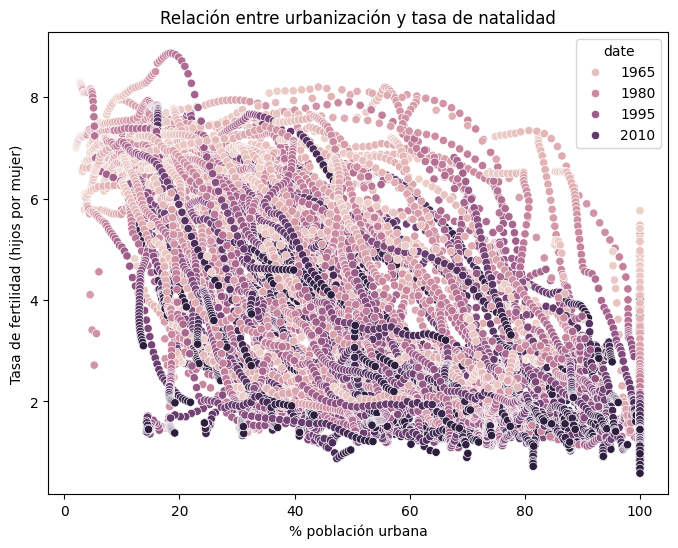

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_pivot,
    x="urban_rate", 
    y="SP.DYN.TFRT.IN", 
    hue='date'
)
plt.title("Relación entre urbanización y tasa de natalidad")
plt.xlabel("% población urbana")
plt.ylabel("Tasa de fertilidad (hijos por mujer)")
plt.show()


In [ ]:
numeric_df = df_pivot.drop(columns=["country_name", "date"]).dropna()
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlaciones entre variables socioeconómicas y natalidad")
plt.show()


NameError: name 'df_pivot' is not defined

In [ ]:

# Csv DIRECTO our world in data
df = pd.read_csv("https://ourworldindata.org/grapher/distribution-of-population-poverty-thresholds.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2743 entries, 0 to 2742
Data columns (total 13 columns):
 #   Column                                                                                                                                                                        Non-Null Count  Dtype 
---  ------                                                                                                                                                                        --------------  ----- 
 0   Entity                                                                                                                                                                        2743 non-null   object
 1   Code                                                                                                                                                                          2241 non-null   object
 2   Year                                                                            